In [0]:
!wget https://nextcloud.qriscloud.org.au/index.php/s/a3KxPawpqkiorST/download

--2020-06-06 10:22:57--  https://nextcloud.qriscloud.org.au/index.php/s/a3KxPawpqkiorST/download
Resolving nextcloud.qriscloud.org.au (nextcloud.qriscloud.org.au)... 203.101.226.175
Connecting to nextcloud.qriscloud.org.au (nextcloud.qriscloud.org.au)|203.101.226.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935276050 (892M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 891.95M  18.1MB/s    in 50s     

2020-06-06 10:23:49 (17.9 MB/s) - ‘download’ saved [935276050/935276050]



In [0]:
!unzip download -d images/

Streaming output truncated to the last 5000 lines.
  inflating: images/20180109-072300-1.jpg  
  inflating: images/20180109-072309-2.jpg  
  inflating: images/20180109-072313-1.jpg  
  inflating: images/20180109-072327-1.jpg  
  inflating: images/20180109-072335-2.jpg  
  inflating: images/20180109-072336-2.jpg  
  inflating: images/20180109-072341-1.jpg  
  inflating: images/20180109-072347-2.jpg  
  inflating: images/20180109-072350-1.jpg  
  inflating: images/20180109-072359-2.jpg  
  inflating: images/20180109-072402-1.jpg  
  inflating: images/20180109-072410-2.jpg  
  inflating: images/20180109-072414-1.jpg  
  inflating: images/20180109-072422-2.jpg  
  inflating: images/20180109-072426-1.jpg  
  inflating: images/20180109-072434-2.jpg  
  inflating: images/20180109-072438-1.jpg  
  inflating: images/20180109-072442-2.jpg  
  inflating: images/20180109-072448-1.jpg  
  inflating: images/20180109-072451-2.jpg  
  inflating: images/20180109-072501-2.jpg  
  inflating: images/20180

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import cv2

print(cv2.__version__)
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


4.1.2
2.2.0


In [0]:
dataset = pd.read_csv("labels.csv")
dataset.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17509 entries, 0 to 17508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  17509 non-null  object
 1   Label     17509 non-null  int64 
 2   Species   17509 non-null  object
dtypes: int64(1), object(2)
memory usage: 410.5+ KB


# Weed Species in dataset

In [0]:
species = list(set(dataset.Species))
species

['Prickly acacia',
 'Snake weed',
 'Parkinsonia',
 'Negative',
 'Lantana',
 'Rubber vine',
 'Parthenium',
 'Chinee apple',
 'Siam weed']

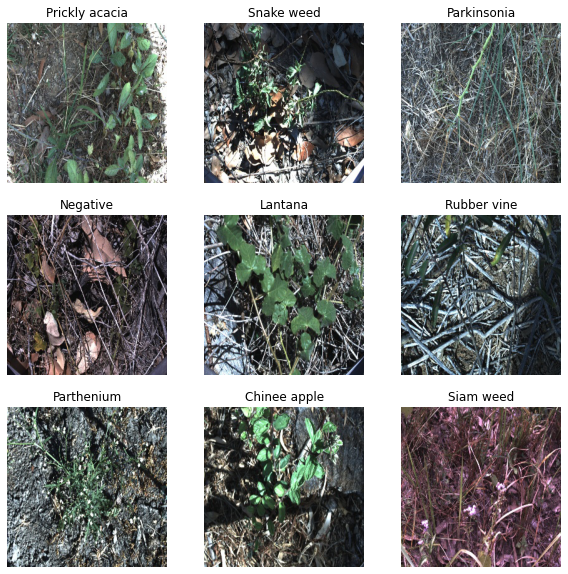

In [0]:
imagesDir = "./images"
speciesSamples = []
for i in species:
    speciesSamples.append(dataset[dataset.Species == i].values[0][0])

matplotlib.rcParams['figure.figsize'] = (10, 10)
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3+j+1)
        img = plt.imread(imagesDir+"/"+speciesSamples[i*3+j])
        plt.axis("off")
        plt.title(species[i*3+j])
        plt.imshow(img)
plt.show()

# Count of images for each species

It's important that the classes have nearly name number of images to avoid bias

In [0]:
speciesCount = {}
for i in species:
    speciesCount[i] = dataset[dataset.Species==i].Species.count()
pd.DataFrame(speciesCount, index = range(1))

,Prickly acacia,Snake weed,Parkinsonia,Negative,Lantana,Rubber vine,Parthenium,Chinee apple,Siam weed
0,1062,1016,1031,9106,1064,1009,1022,1125,1074


Total Species Count = 8439

Each Species = 1000 Images Approx.

Negetive images are almost equal to images of weeds. So dataset is balanced.

# Making CNN

In [0]:
image = plt.imread(imagesDir+"/"+speciesSamples[0])
image.shape

(256, 256, 3)

In [0]:
import random
CLASSES_NAME = ['Negative', 'Prickly acacia', 'Parthenium', 'Parkinsonia', 'Chinee apple', 'Lantana', 'Siam weed', 'Snake weed', 'Rubber vine']
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)


dataset = dataset.sample(frac=1).reset_index(drop=True)
border = len(dataset)-2000
trainDataset = dataset[:border]
valDataset = dataset[border:]

trainDatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    fill_mode="constant",
    # shear_range=0.2,
    # zoom_range=(0.5, 1),
    horizontal_flip=True,
    rotation_range=360,
    # channel_shift_range=25,
    # brightness_range=(0.75, 1.25)
)

valDatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    fill_mode="constant",
    # shear_range=0.2,
    # zoom_range=(0.5, 1),
    horizontal_flip=True,
    rotation_range=360,
    # channel_shift_range=25,
    # brightness_range=(0.75, 1.25)
)


trainGenerator = trainDatagen.flow_from_dataframe(
            trainDataset,
            imagesDir,
            target_size=(200, 200),
            x_col='Filename',
            y_col='Species',
            # target_size=RAW_IMG_SIZE,
            batch_size=128,
            classes=CLASSES_NAME,
            class_mode='categorical'
)

valGenerator = valDatagen.flow_from_dataframe(
            valDataset,
            imagesDir,
            target_size=(200, 200),
            x_col='Filename',
            y_col='Species',
            # target_size=RAW_IMG_SIZE,
            classes=CLASSES_NAME,
            batch_size=128,
            class_mode='categorical'
)

Found 15509 validated image filenames belonging to 9 classes.
Found 2000 validated image filenames belonging to 9 classes.


In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 2, activation='relu', input_shape=(200, 200, 3)))
model.add(tf.keras.layers.Conv2D(64, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, 2, activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 2, activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(10000, activation='relu'))
# model.add(tf.keras.layers.Dense(2000, activation='relu'))
# model.add(tf.keras.layers.Dense(500, activation='relu'))
# model.add(tf.keras.layers.Dense(2000, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(len(CLASSES), activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 199, 199, 64)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 64)      16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 128)       32896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 128)       65664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        3

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['categorical_accuracy'])
history = model.fit(trainGenerator, validation_data = valGenerator, epochs=10)

Epoch 1/10
122/122 [==============================] - 181s 1s/step - loss: 0.3025 - categorical_accuracy: 0.5098 - val_loss: 0.2801 - val_categorical_accuracy: 0.5100
Epoch 2/10
122/122 [==============================] - 178s 1s/step - loss: 0.2764 - categorical_accuracy: 0.5214 - val_loss: 0.2793 - val_categorical_accuracy: 0.5100
Epoch 3/10
122/122 [==============================] - 176s 1s/step - loss: 0.2713 - categorical_accuracy: 0.5212 - val_loss: 0.2662 - val_categorical_accuracy: 0.5100
Epoch 4/10
122/122 [==============================] - 176s 1s/step - loss: 0.2538 - categorical_accuracy: 0.5216 - val_loss: 0.2583 - val_categorical_accuracy: 0.5100
Epoch 5/10
122/122 [==============================] - 176s 1s/step - loss: 0.2482 - categorical_accuracy: 0.5258 - val_loss: 0.2445 - val_categorical_accuracy: 0.5185
Epoch 6/10
122/122 [==============================] - 179s 1s/step - loss: 0.2422 - categorical_accuracy: 0.5298 - val_loss: 0.2412 - val_categorical_accuracy: 0.529

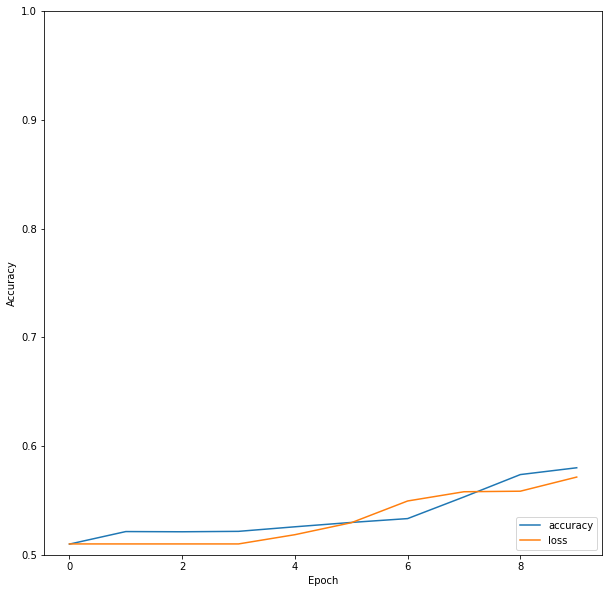

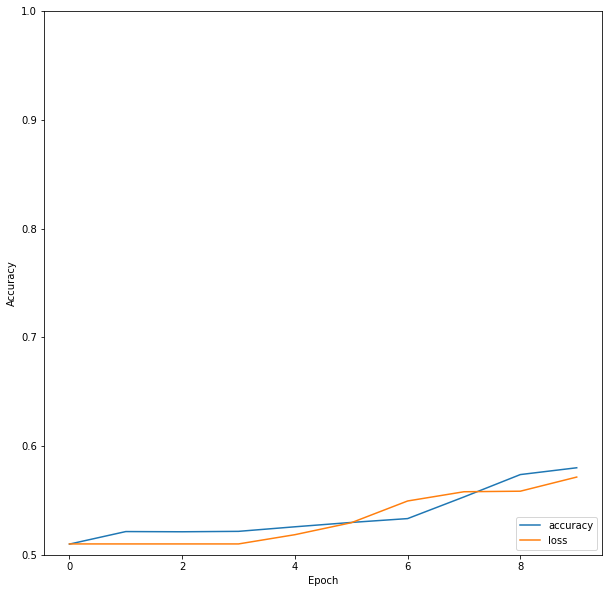

In [0]:
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [0]:
def getPrediction(image):
  image = plt.imread(imagesDir+"/"+speciesSamples[0])
  image = cv2.resize(image, (200, 200))
  np.rollaxis(image, 2, 1)  
  image=image/255.
  images = np.array([image])
  images.shape
  # print(image[1:10])
  return CLASSES[np.argmax(model.predict(images))]

In [0]:
prediction = []
for i in trainDataset.values:
  prediction.append(getPrediction(i[0]))
len(prediction)

15509

15509

In [0]:
np.unique(prediction)

In [0]:
model.predict_classes

In [0]:
trainGenerator.class_indices

In [0]:
", ".join(species)